In [31]:
import numpy as np
import pandas as pd

years = [str(i) for i in range(1993, 2022)]
monthes = ['06', '11']
file_path = 'data/TOP500_lists/TOP500_{}.{}'

data = dict()
for year in years:
    for month in monthes:
        date_string = year + month
        suffix = 'xls'
        if (date_string > '2020'):
            suffix = 'xlsx'
        data[year + '/' + month] = pd.read_excel(file_path.format(date_string, suffix))

In [32]:
def processor_name_to_one_format(name):
    # print(name)
    c = name.split('GHz')
    if len(c) > 2:
        print('ERROR')
    while c[0][-1] == '0':
        # print('!!!!!!!!!!!!!!!!!!')
        c[0] = c[0][:-1:]
    if c[0][-1] == '.':
        c[0] = c[0][:-1:]
    res = 'GHz'.join(c)
    # print(res)
    return res

In [33]:
data['2021/11'][data['2021/11']['Processor'] == 'AMD EPYC 7302 32C 3GHz']

,Rank,Previous Rank,First Appearance,First Rank,Name,Computer,Site,Manufacturer,Country,Year,...,Accelerator/Co-Processor,Cores per Socket,Processor Generation,System Model,System Family,Interconnect Family,Interconnect,Continent,Site ID,System ID
94,95,NaN,58,95,"DiRAC, Tursa","BullSequana XH2000, AMD EPYC 7302 32C 3GHz, NV...",University of Edinburgh,Atos,United Kingdom,2021,...,NVIDIA A100 40GB,32,AMD Rome,BullSequana XH2000,BullSequana,Infiniband,Mellanox HDR Infiniband,Europe,49151,180018


In [34]:
data['2011/11'].columns

Index(['Rank', 'Name', 'Computer', 'Site', 'Manufacturer', 'Country', 'Year',
       'Segment', 'Total Cores', 'Accelerator Cores', 'Rmax', 'Rpeak',
       'Effeciency (%)', 'Nmax', 'Nhalf', 'Power', 'Mflops/Watt',
       'Architecture', 'Processor', 'Processor Technology',
       'Processor Speed (MHz)', 'Operating System', 'OS Family', 'Accelerator',
       'Cores per Socket', 'Processor Generation', 'System Model',
       'System Family', 'Interconnect Family', 'Interconnect', 'Region',
       'Continent'],
      dtype='object')

In [35]:
def get_real_columns_list(col_start, *rules, add_hpcg=False):
    col_end = col_start.copy()
    for rule in rules:
        for column in rule:
            # print(column)
            col_end.remove(column)
            col_end.add(rule[column])
    if add_hpcg:
        col_start.add('HPCG [TFlop/s]')
    return col_end
            
def revert_dict(d):
    rev_d = {}
    for key in d:
        rev_d[d[key]] = key
    return rev_d


In [71]:
column_list_start = set([
    'Cores per Socket', 
    'Total Cores', 
    'Rpeak', 
    'Rmax', 
    'Power', 
    'Processor', 
    'Processor Technology', 
    'Processor Generation', 
    'Processor Speed (MHz)', 
    'Accelerator', 
    'Accelerator Cores',
])

rename_rule_1 = {
    'Accelerator Cores': 'Accelerator/Co-Processor Cores',
    'Accelerator': 'Accelerator/Co-Processor',
}

rename_rule_2 = {
    'Power': 'Power (kW)',
    'Rpeak': 'Rpeak [TFlop/s]',
    'Rmax': 'Rmax [TFlop/s]'
}

accelerator_df = pd.DataFrame(columns=['per_cnt', 'per_rmax', 'per_rpeak', 'year'])

df = None
for date_string in data:
    # print(date_string)
    res = None
    if date_string < '2011/11':
        continue
    elif date_string < '2012/06':
        res = data[date_string].loc[:, column_list_start]
    elif date_string < '2017/06':
        columns_to_import = get_real_columns_list(column_list_start, rename_rule_1)
        res = data[date_string].loc[:, columns_to_import]
        res.rename(columns = revert_dict(rename_rule_1), inplace = True)
    else:
        columns_to_import = get_real_columns_list(column_list_start, rename_rule_1, rename_rule_2, add_hpcg=True)
        res = data[date_string].loc[:, columns_to_import]
        res.rename(columns = revert_dict(rename_rule_1), inplace = True)
        res.rename(columns = revert_dict(rename_rule_2), inplace = True)
        res.rename(columns = {'HPCG [TFlop/s]': 'HPCG'}, inplace = True)
        res['Rpeak'] = res['Rpeak'] * (10 ** 3)
        res['Rmax'] = res['Rmax'] * (10 ** 3)

    res.loc[:, 'PubDate'] = date_string
    res.loc[:, 'PubYear'] = date_string[:4]
    res.loc[:, 'PubMonth'] = date_string[5:]
    rmax_sum = res['Rmax'].sum()
    rpeak_sum = res['Rpeak'].sum()
    
    res['use_accelerator'] = ~((res['Accelerator'] == 'None') & ((res['Accelerator Cores'] == 0) | (res['Accelerator Cores'].isna())))
    percent_accelerator = res['use_accelerator'].sum() / res.shape[0] * 100
    print('PERC_ACCELERATOR:', percent_accelerator)
    print('COUNT_ACCELERATOR', res['use_accelerator'].sum())
    print('---------------------------------')
    rmax_accelerator = np.sum(res['Rmax'] * res['use_accelerator'])
    rpeak_accelerator = np.sum(res['Rpeak'] * res['use_accelerator'])
    percent_rmax_accelerator = rmax_accelerator / rmax_sum * 100
    percent_rpeak_accelerator = rpeak_accelerator / rpeak_sum * 100
    
    print('RMAX_SUM:', rmax_sum)
    print('RMAX_ACCELERATOR:', rmax_accelerator)
    print('PERC_RMAX_ACCELERATOR:', percent_rmax_accelerator)
    print('---------------------------------')
    print('RPEAK_SUM:', rpeak_sum)
    print('RPEAK_ACCELERATOR:', rpeak_accelerator)
    print('PERC_RPEAK_ACCELERATOR:', percent_rpeak_accelerator)
    print('**********************************')
    accelerator_df = accelerator_df.append({
        'per_cnt': percent_accelerator, 
        'per_rmax': percent_rmax_accelerator, 
        'per_rpeak': percent_rpeak_accelerator,
        'year': date_string
    }, ignore_index=True)
    
    res['cnt_percent'] = 100 / (res.shape[0] - res['use_accelerator'].sum())
    res['Rmax_percent'] = res['Rmax'] / (rmax_sum - rmax_accelerator) * 100
    res['Rpeak_percent'] = res['Rpeak'] / (rpeak_sum - rpeak_accelerator) * 100
    # print(res.columns)
    if df is None:
        df = res
    else:
        df = pd.concat([df, res], ignore_index=True)
df

PERC_ACCELERATOR: 7.8
COUNT_ACCELERATOR 39
---------------------------------
RMAX_SUM: 74069633.67999999
RMAX_ACCELERATOR: 11148246.0
PERC_RMAX_ACCELERATOR: 15.051034339069789
---------------------------------
RPEAK_SUM: 107627649.53999999
RPEAK_ACCELERATOR: 21931818.480000004
PERC_RPEAK_ACCELERATOR: 20.37749460639202
**********************************
PERC_ACCELERATOR: 11.600000000000001
COUNT_ACCELERATOR 58
---------------------------------
RMAX_SUM: 123417786.71
RMAX_ACCELERATOR: 16314638.84
PERC_RMAX_ACCELERATOR: 13.219033718644784
---------------------------------
RPEAK_SUM: 171871144.53
RPEAK_ACCELERATOR: 31254323.32
PERC_RPEAK_ACCELERATOR: 18.184741484946926
**********************************
PERC_ACCELERATOR: 12.4
COUNT_ACCELERATOR 62
---------------------------------
RMAX_SUM: 162139386.75
RMAX_ACCELERATOR: 37295378.31
PERC_RMAX_ACCELERATOR: 23.002047224654376
---------------------------------
RPEAK_SUM: 229275911.79999998
RPEAK_ACCELERATOR: 64108141.76
PERC_RPEAK_ACCELERATOR:

,Cores per Socket,Processor Speed (MHz),Rmax,Rpeak,Power,Processor,Accelerator,Accelerator Cores,Processor Generation,Total Cores,Processor Technology,PubDate,PubYear,PubMonth,use_accelerator,cnt_percent,Rmax_percent,Rpeak_percent,HPCG
0,8,2000,10510000.0,11280384.0,12659.89,SPARC64 VIIIfx 8C 2.00GHz,None,0.0,SPARC64 VIIIfx,705024,Sparc,2011/11,2011,11,False,0.216920,16.703382,13.163282,NaN
1,6,2930,2566000.0,4701000.0,4040.00,Xeon X5670 6C 2.93GHz,NVIDIA 2050,100352.0,Xeon X56xx (Westmere-EP),186368,Intel Nehalem,2011/11,2011,11,True,0.216920,4.078105,5.485681,NaN
2,6,2600,1759000.0,2331000.0,6950.00,Opteron Six Core 6C 2.60GHz,None,0.0,Opteron Six Core,224162,AMD x86_64,2011/11,2011,11,False,0.216920,2.795552,2.720086,NaN
3,6,2660,1271000.0,2984300.0,2580.00,Xeon X5650 6C 2.66GHz,NVIDIA 2050,64960.0,Xeon X56xx (Westmere-EP),120640,Intel Nehalem,2011/11,2011,11,True,0.216920,2.019981,3.482433,NaN
4,6,2930,1192000.0,2287630.0,1398.61,Xeon X5670 6C 2.93GHz,NVIDIA 2050,56994.0,Xeon X56xx (Westmere-EP),73278,Intel Nehalem,2011/11,2011,11,True,0.216920,1.894427,2.669476,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN
10496,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN
10497,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN
10498,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN


In [72]:
accelerator_df

,per_cnt,per_rmax,per_rpeak,year
0,7.8,15.051034,20.377495,2011/11
1,11.6,13.219034,18.184741,2012/06
2,12.4,23.002047,27.961133,2012/11
3,10.8,33.742769,38.460577,2013/06
4,10.6,35.118997,39.047484,2013/11
5,12.8,34.534409,37.549864,2014/06
6,15.0,34.415909,38.175161,2014/11
7,18.0,33.719882,37.844062,2015/06
8,20.6,31.703873,33.018397,2015/11
9,18.8,23.668437,25.186716,2016/06


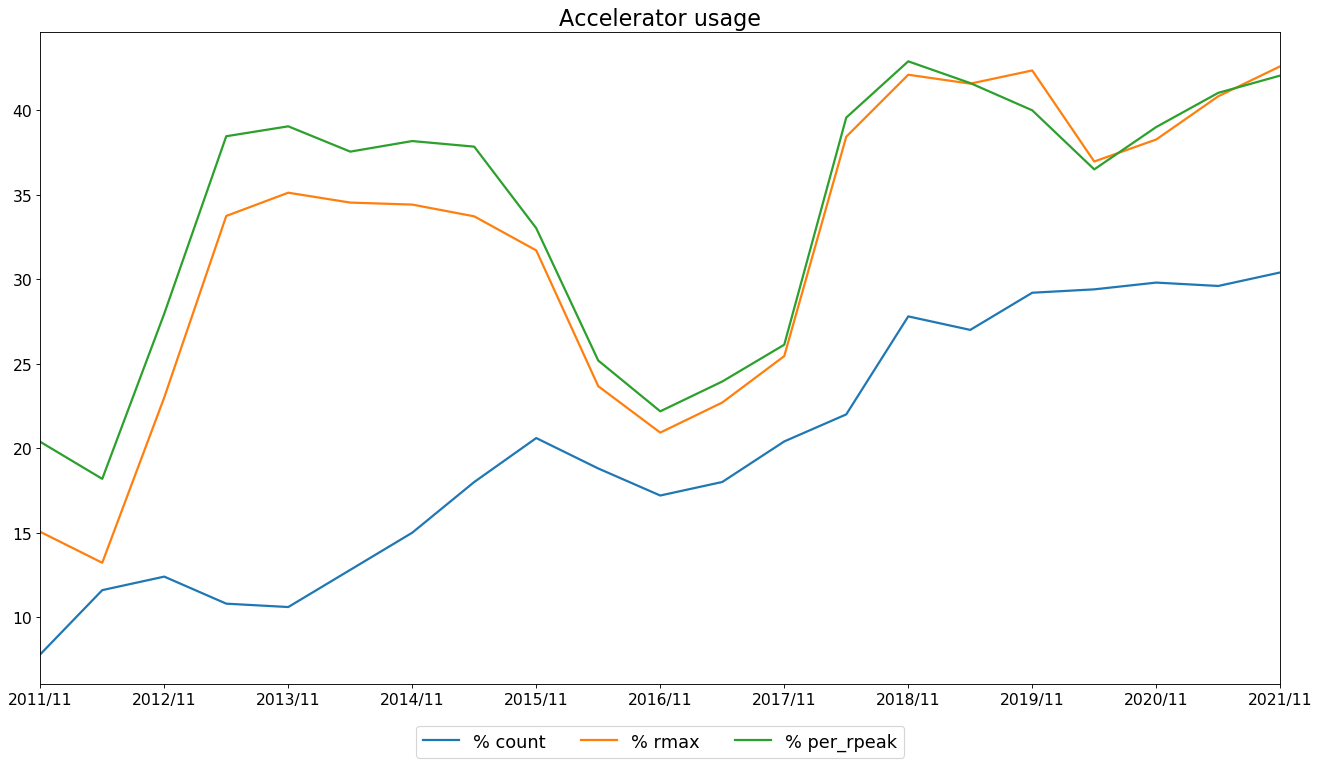

In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 12), dpi=80)

columns = {'per_cnt': '% count', 'per_rmax': '% rmax', 'per_rpeak': '% per_rpeak'}

x = accelerator_df['year'].values.tolist()

for column in columns:
    ax.plot(x, accelerator_df[column].values.tolist(), linewidth=2.0, label=columns[column])

plt.xticks(x[::2], fontsize=14, horizontalalignment='center')
plt.yticks(fontsize=14)
ax.set_title('Accelerator usage', fontsize=20)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
             box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fontsize=16, ncol=5)

plt.xlim(x[0], x[-1])
plt.show()

In [74]:
df['Processor'] = df['Processor'].apply(processor_name_to_one_format)

In [75]:
df[(df['Accelerator'] != 'None') & ~((df['Accelerator Cores'] != 0) & (~df['Accelerator Cores'].isna()))]

,Cores per Socket,Processor Speed (MHz),Rmax,Rpeak,Power,Processor,Accelerator,Accelerator Cores,Processor Generation,Total Cores,Processor Technology,PubDate,PubYear,PubMonth,use_accelerator,cnt_percent,Rmax_percent,Rpeak_percent,HPCG
20,4,2267,496500.0,1012650.0,540.00,Xeon X5520 4C 2.27GHz,NVIDIA 2050,0.0,Xeon X55xx (Nehalem-EP),29440,Intel EM64T,2011/11,2011,11,True,0.216920,0.789080,1.181679,NaN
32,12,2100,299300.0,508499.2,416.78,Opteron 6172 12C 2.1GHz,ATI GPU,0.0,Opteron 12 Core,16368,AMD x86_64,2011/11,2011,11,True,0.216920,0.475673,0.593377,NaN
88,9,3200,126500.0,161856.0,276.00,PowerXCell 8i 9C 3.2GHz,IBM PowerXCell 8i,0.0,PowerXCell 8i,14400,Power,2011/11,2011,11,True,0.216920,0.201045,0.188873,NaN
505,16,2200,1941000.0,2627609.0,5142.00,Opteron 6274 16C 2.2GHz,NVIDIA 2090,0.0,"Opteron 6200 Series ""Interlagos""",298592,AMD x86_64,2012/06,2012,06,True,0.226244,1.812272,1.868631,NaN
536,4,2267,496500.0,1012650.0,540.00,Xeon X5520 4C 2.267GHz,NVIDIA 2050,0.0,Xeon 5500-series (Nehalem-EP),29440,Intel Nehalem,2012/06,2012,06,True,0.226244,0.463572,0.720149,NaN
558,12,2100,299300.0,508499.2,416.78,Opteron 6172 12C 2.1GHz,ATI GPU,0.0,"Opteron 6100-series ""Magny-Cours""",16368,AMD x86_64,2012/06,2012,06,True,0.226244,0.279450,0.361620,NaN
636,9,3200,126500.0,161856.0,276.00,PowerXCell 8i 9C 3.2GHz,IBM PowerXCell 8i,0.0,PowerXCell 8i,14400,Power,2012/06,2012,06,True,0.226244,0.118110,0.115104,NaN
799,6,2660,79320.0,88099.2,225.00,Xeon X5650 6C 2.66GHz,NVIDIA 2070,0.0,Xeon 5600-series (Westmere-EP),8280,Intel Nehalem,2012/06,2012,06,True,0.226244,0.074059,0.062652,NaN
1042,4,2267,496500.0,1012650.0,540.00,Xeon X5520 4C 2.267GHz,NVIDIA 2050,0.0,Xeon 5500-series (Nehalem-EP),29440,Intel Nehalem,2012/11,2012,11,True,0.228311,0.397696,0.613104,NaN
1083,12,2100,299300.0,508499.2,416.78,Opteron 6172 12C 2.1GHz,ATI GPU,0.0,"Opteron 6100-series ""Magny-Cours""",16368,AMD x86_64,2012/11,2012,11,True,0.228311,0.239739,0.307868,NaN


In [76]:
df['not_accelerator'] = (df['Accelerator'] == 'None') & ((df['Accelerator Cores'] == 0) | (df['Accelerator Cores'].isna()))                                 

In [77]:
df

,Cores per Socket,Processor Speed (MHz),Rmax,Rpeak,Power,Processor,Accelerator,Accelerator Cores,Processor Generation,Total Cores,Processor Technology,PubDate,PubYear,PubMonth,use_accelerator,cnt_percent,Rmax_percent,Rpeak_percent,HPCG,not_accelerator
0,8,2000,10510000.0,11280384.0,12659.89,SPARC64 VIIIfx 8C 2GHz,None,0.0,SPARC64 VIIIfx,705024,Sparc,2011/11,2011,11,False,0.216920,16.703382,13.163282,NaN,True
1,6,2930,2566000.0,4701000.0,4040.00,Xeon X5670 6C 2.93GHz,NVIDIA 2050,100352.0,Xeon X56xx (Westmere-EP),186368,Intel Nehalem,2011/11,2011,11,True,0.216920,4.078105,5.485681,NaN,False
2,6,2600,1759000.0,2331000.0,6950.00,Opteron Six Core 6C 2.6GHz,None,0.0,Opteron Six Core,224162,AMD x86_64,2011/11,2011,11,False,0.216920,2.795552,2.720086,NaN,True
3,6,2660,1271000.0,2984300.0,2580.00,Xeon X5650 6C 2.66GHz,NVIDIA 2050,64960.0,Xeon X56xx (Westmere-EP),120640,Intel Nehalem,2011/11,2011,11,True,0.216920,2.019981,3.482433,NaN,False
4,6,2930,1192000.0,2287630.0,1398.61,Xeon X5670 6C 2.93GHz,NVIDIA 2050,56994.0,Xeon X56xx (Westmere-EP),73278,Intel Nehalem,2011/11,2011,11,True,0.216920,1.894427,2.669476,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True
10496,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True
10497,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True
10498,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True


In [78]:
import matplotlib.pyplot as plt
import re

def build_plot(data, title, regex_string, cut_to=6, legend_fontsize=14):
    reg_expr = re.compile(regex_string)
    columns = []
    for column in res.columns:
        if reg_expr.search(column) != None:
            columns.append(column)
    x = data['PubDate'].values.tolist()
    ys = []
    labs = []
    for column in columns:
        if (data[column] != 0.).sum() != 0:
            ys.append(data[column].values.tolist())
            labs.append(column[:-cut_to])
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 12), dpi=80)
    y = np.vstack(ys)
    ax = plt.gca()
    
    cm = plt.cm.get_cmap('tab20')
    ax.stackplot(x, y, labels=labs, alpha=0.8, colors=cm.colors)
    plt.xticks(x[::3], fontsize=12, horizontalalignment='center')
    plt.yticks(fontsize=12)
    ax.set_title(title, fontsize=18)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fontsize=legend_fontsize, ncol=5)

    plt.ylim(0, 1)
    plt.xlim(x[0], x[-1])
    plt.show()

In [79]:
df = df[(df['Accelerator'] == 'None') & ((df['Accelerator Cores'] == 0) | (df['Accelerator Cores'].isna()))]

In [80]:
df

,Cores per Socket,Processor Speed (MHz),Rmax,Rpeak,Power,Processor,Accelerator,Accelerator Cores,Processor Generation,Total Cores,Processor Technology,PubDate,PubYear,PubMonth,use_accelerator,cnt_percent,Rmax_percent,Rpeak_percent,HPCG,not_accelerator
0,8,2000,10510000.0,11280384.0,12659.89,SPARC64 VIIIfx 8C 2GHz,None,0.0,SPARC64 VIIIfx,705024,Sparc,2011/11,2011,11,False,0.216920,16.703382,13.163282,NaN,True
2,6,2600,1759000.0,2331000.0,6950.00,Opteron Six Core 6C 2.6GHz,None,0.0,Opteron Six Core,224162,AMD x86_64,2011/11,2011,11,False,0.216920,2.795552,2.720086,NaN,True
5,8,2400,1110000.0,1365811.2,3980.00,Opteron 6136 8C 2.4GHz,None,0.0,Opteron 8 Core,142272,AMD x86_64,2011/11,2011,11,False,0.216920,1.764106,1.593790,NaN,True
6,4,3000,1088000.0,1315328.0,4102.00,Xeon E5450 4C 3GHz,None,0.0,"Xeon 5400-series ""Harpertown""",111104,Intel Core,2011/11,2011,11,False,0.216920,1.729142,1.534880,NaN,True
7,12,2100,1054000.0,1288627.2,2910.00,Opteron 6172 12C 2.1GHz,None,0.0,Opteron 12 Core,153408,AMD x86_64,2011/11,2011,11,False,0.216920,1.675106,1.503722,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True
10496,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True
10497,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True
10498,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True


In [81]:
### Удалили все ненужные колонки с accelerator cores

In [82]:
df.drop(columns=['Accelerator', 'Accelerator Cores'])

,Cores per Socket,Processor Speed (MHz),Rmax,Rpeak,Power,Processor,Processor Generation,Total Cores,Processor Technology,PubDate,PubYear,PubMonth,use_accelerator,cnt_percent,Rmax_percent,Rpeak_percent,HPCG,not_accelerator
0,8,2000,10510000.0,11280384.0,12659.89,SPARC64 VIIIfx 8C 2GHz,SPARC64 VIIIfx,705024,Sparc,2011/11,2011,11,False,0.216920,16.703382,13.163282,NaN,True
2,6,2600,1759000.0,2331000.0,6950.00,Opteron Six Core 6C 2.6GHz,Opteron Six Core,224162,AMD x86_64,2011/11,2011,11,False,0.216920,2.795552,2.720086,NaN,True
5,8,2400,1110000.0,1365811.2,3980.00,Opteron 6136 8C 2.4GHz,Opteron 8 Core,142272,AMD x86_64,2011/11,2011,11,False,0.216920,1.764106,1.593790,NaN,True
6,4,3000,1088000.0,1315328.0,4102.00,Xeon E5450 4C 3GHz,"Xeon 5400-series ""Harpertown""",111104,Intel Core,2011/11,2011,11,False,0.216920,1.729142,1.534880,NaN,True
7,12,2100,1054000.0,1288627.2,2910.00,Opteron 6172 12C 2.1GHz,Opteron 12 Core,153408,AMD x86_64,2011/11,2011,11,False,0.216920,1.675106,1.503722,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True
10496,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True
10497,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True
10498,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True


In [83]:
df

,Cores per Socket,Processor Speed (MHz),Rmax,Rpeak,Power,Processor,Accelerator,Accelerator Cores,Processor Generation,Total Cores,Processor Technology,PubDate,PubYear,PubMonth,use_accelerator,cnt_percent,Rmax_percent,Rpeak_percent,HPCG,not_accelerator
0,8,2000,10510000.0,11280384.0,12659.89,SPARC64 VIIIfx 8C 2GHz,None,0.0,SPARC64 VIIIfx,705024,Sparc,2011/11,2011,11,False,0.216920,16.703382,13.163282,NaN,True
2,6,2600,1759000.0,2331000.0,6950.00,Opteron Six Core 6C 2.6GHz,None,0.0,Opteron Six Core,224162,AMD x86_64,2011/11,2011,11,False,0.216920,2.795552,2.720086,NaN,True
5,8,2400,1110000.0,1365811.2,3980.00,Opteron 6136 8C 2.4GHz,None,0.0,Opteron 8 Core,142272,AMD x86_64,2011/11,2011,11,False,0.216920,1.764106,1.593790,NaN,True
6,4,3000,1088000.0,1315328.0,4102.00,Xeon E5450 4C 3GHz,None,0.0,"Xeon 5400-series ""Harpertown""",111104,Intel Core,2011/11,2011,11,False,0.216920,1.729142,1.534880,NaN,True
7,12,2100,1054000.0,1288627.2,2910.00,Opteron 6172 12C 2.1GHz,None,0.0,Opteron 12 Core,153408,AMD x86_64,2011/11,2011,11,False,0.216920,1.675106,1.503722,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True
10496,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True
10497,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True
10498,20,2300,1649110.0,2119680.0,NaN,Xeon E5-2673v4 20C 2.3GHz,None,NaN,Intel Xeon E5 (Broadwell),57600,Intel Broadwell,2021/11,2021,11,False,0.287356,0.094604,0.076382,NaN,True


In [84]:
print(len(df['Processor'].unique()))

247


In [85]:
print(len((df['Processor'] + df['Processor Technology'] + df['Processor Generation']).unique()))

286


In [86]:
d = dict()
for i, row in df.iterrows():
    name = row['Processor']
    tchn = row['Processor Technology']
    gen = row['Processor Generation']
    if name not in d:
        d[name] = set()
    d[name].add(tchn + ' |&| ' + gen)
for key in d:
    if len(d[key]) > 1:
        print(key, d[key])

Opteron 6136 8C 2.4GHz {'AMD x86_64 |&| Opteron 8 Core', 'AMD x86_64 |&| Opteron 6100-series "Magny-Cours" '}
Xeon E5450 4C 3GHz {'Intel Core |&| Xeon 5400-series "Harpertown"', 'Intel Core |&| Xeon X54xx (Harpertown)'}
Opteron 6172 12C 2.1GHz {'AMD x86_64 |&| Opteron 12 Core', 'AMD x86_64 |&| Opteron 6100-series "Magny-Cours" '}
Xeon X7560 8C 2.26GHz {'Intel Nehalem |&| Xeon 5500-series (Nehalem-EX)', 'Intel Nehalem |&| Xeon 75xx (Nehalem-EX)'}
Opteron 6276 16C 2.3GHz {'AMD x86_64 |&| Opteron 6200 Series', 'AMD x86_64 |&| Opteron 6200 Series "Interlagos"'}
ShenWei processor SW1600 16C 975MHz {'ShenWei |&| ShenWei', 'Others |&| ShenWei'}
Xeon X5570 4C 2.93GHz {'Intel EM64T |&| Xeon X55xx (Nehalem-EP)', 'Intel Nehalem |&| Xeon 5500-series (Nehalem-EP)'}
Opteron 6272 16C 2.1GHz {'AMD x86_64 |&| Opteron 6200 Series', 'AMD x86_64 |&| Opteron 6200 Series "Interlagos"'}
Opteron 6174 12C 2.2GHz {'AMD x86_64 |&| Opteron 12 Core', 'AMD x86_64 |&| Opteron 6100-series "Magny-Cours" '}
Xeon X5680 

In [89]:
def get_stats(pr_name, df):
    # processor, processor generation, processor_technology, min_date, max_date, cores, threads, power, boost_frequency, price, price_per_power, peak_performance, cache_memory, num_occurence
    values_dict = {'Processor': pr_name, 'Threads': None, 'Boost Frequency': None, 'Price': None, 'Cache Memory': None}
    relevance = 0
    relevance_rpeak = 0
    relevance_rmax = 0
    cores = None
    min_date = None
    max_date = None
    processor_technology = None
    processor_generation = None
    power = 0
    power_count = 0
    RPeak = 0
    RMax = 0
    HPCG = 0
    hpcg_count = 0
    for i, row in df.iterrows():
        if row['Processor'] != pr_name:
            continue
        relevance += row['cnt_percent']
        relevance_rpeak += row['Rmax_percent']
        relevance_rmax += row['Rpeak_percent']
        if min_date is None:
            min_date = row['PubDate']
            max_date = row['PubDate']
        else:
            min_date = min(row['PubDate'], min_date)
            max_date = max(row['PubDate'], max_date)
        if cores is None:
            cores = row['Cores per Socket']
        elif cores != row['Cores per Socket']:
            print('CORES ERROR: ', pr_name, ' (', cores, ' -> ', row['Cores per Socket'], ')', sep='')
        if max_date == row['PubDate']:
            processor_technology = row['Processor Technology']
            processor_generation = row['Processor Generation']
        if row['Power'] != np.nan:
            power += row['Power'] / row['Total Cores']
            power_count += 1
        RPeak += row['Rpeak'] / row['Total Cores']
        RMax += row['Rmax'] / row['Total Cores']
        if row['HPCG'] != np.nan:
            HPCG += row['HPCG'] / row['Total Cores']
            hpcg_count += 1
    values_dict['Processor Technology'] = processor_technology
    values_dict['Processor Generation'] = processor_generation
    if hpcg_count != 0:
        values_dict['HPCG'] = HPCG / hpcg_count
    else:
        values_dict['HPCG'] = None
    values_dict['RMax'] = RMax / relevance
    values_dict['RPeak'] = RPeak / relevance
    if power_count != 0:
        values_dict['Power'] = 1000 * power / power_count
    else:
        values_dict['Power'] = None
    values_dict['Min Date'] = min_date
    values_dict['Max Date'] = max_date
    values_dict['Cores'] = cores
    values_dict['Relevance_cnt'] = relevance
    values_dict['Relevance_Rmax'] = relevance_rmax
    values_dict['Relevance_Rpeak'] = relevance_rpeak
    return values_dict

In [93]:
res_df = pd.DataFrame(columns=[
    'Processor', 'Processor Technology', 'Processor Generation', 'Price',
       'Manufacture RMax', 'Manufacture RPeak', 'Manufacture Power', 'Threads',
       'Frequency', 'Boost Frequency', 'Cache', 'HPCG', 'RMax', 'RPeak', 'Power',
       'Min Date', 'Max Date', 'Cores', 'Relevance_cnt', 'Relevance_Rmax', 'Relevance_Rpeak'])
for key in d:
    stats = get_stats(key, df)
    if res_df is None:
        res_df = pd.DataFrame(stats)
    else:
        res_df = res_df.append(stats, ignore_index=True)
res_df

,Processor,Processor Technology,Processor Generation,Price,Manufacture RMax,Manufacture RPeak,Manufacture Power,Threads,Frequency,Boost Frequency,...,RMax,RPeak,Power,Min Date,Max Date,Cores,Relevance_cnt,Relevance_Rmax,Relevance_Rpeak,Cache Memory
0,SPARC64 VIIIfx 8C 2GHz,Sparc,SPARC64 VIIIfx,None,NaN,NaN,NaN,None,NaN,None,...,61.628270,66.145629,17.956679,2011/11,2019/06,8,3.870248,61.701543,79.348677,None
1,Opteron Six Core 6C 2.6GHz,AMD x86_64,Opteron Six Core,None,NaN,NaN,NaN,None,NaN,None,...,35.067445,46.446192,NaN,2011/11,2013/11,6,2.015093,7.040604,7.313902,None
2,Opteron 6136 8C 2.4GHz,AMD x86_64,"Opteron 6100-series ""Magny-Cours""",None,NaN,NaN,NaN,None,NaN,None,...,30.096540,42.057660,NaN,2011/11,2017/11,8,6.859299,9.789389,10.372586,None
3,Xeon E5450 4C 3GHz,Intel Core,"Xeon 5400-series ""Harpertown""",None,NaN,NaN,NaN,None,NaN,None,...,40.859567,53.283456,NaN,2011/11,2015/11,4,8.759563,8.555172,8.762900,None
4,Opteron 6172 12C 2.1GHz,AMD x86_64,"Opteron 6100-series ""Magny-Cours""",None,NaN,NaN,NaN,None,NaN,None,...,28.321005,36.921259,NaN,2011/11,2015/11,12,15.713075,16.004544,17.063939,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,Xeon Platinum 8360Y 36C 2.4GHz,Intel Ice Lake,Xeon® Platinum 83xx (Ice Lake),None,NaN,NaN,NaN,None,NaN,None,...,165.369478,268.791125,NaN,2021/06,2021/11,36,0.571447,0.656176,0.639203,None
243,Xeon Gold 6230R 26C 2.1GHz,Intel Cascade lake,Xeon Gold 62xx (Cascade Lake),None,NaN,NaN,NaN,None,NaN,None,...,108.007698,235.192320,NaN,2021/06,2021/11,26,1.142894,0.885595,0.643741,None
244,AMD EPYC 7763 64C 2.45GHz,AMD Zen-3 (Milan),AMD Milan,None,NaN,NaN,NaN,None,NaN,None,...,103.386464,134.494893,NaN,2021/06,2021/11,64,2.579676,2.523135,2.996411,None
245,Xeon Platinum 8358 32C 2.6GHz,Intel Ice Lake,Xeon® Platinum 83xx (Ice Lake),None,NaN,NaN,NaN,None,NaN,None,...,204.424219,289.535742,NaN,2021/11,2021/11,32,0.287356,0.178062,0.200143,None


In [94]:
res_df['Relevance_Rmax'].sum()

2100.0000000000005

In [95]:
print(res_df['Relevance_Rpeak'].sum())
print(res_df['Relevance_Rmax'].sum())

2100.0
2100.0000000000005


In [96]:
res_df['Power'].isna().sum()

187

In [97]:
res_df['HPCG'].isna().sum()

241

In [98]:
res_df.to_excel("data/processors_v1_draft.xlsx")

In [99]:
res_df.shape

(247, 22)

In [100]:
df_v0 = pd.read_excel('data/processors_v0.xlsx')

In [101]:
df_v0['Processor'] = df_v0['Processor'].apply(processor_name_to_one_format)

In [102]:
df_v1 = pd.read_excel('data/processors_v1_draft.xlsx')

In [103]:
df_v0.columns

Index(['Processor Generation', 'Processor Technology', 'Processor', 'Cores',
       'Threads', 'Frequency', 'Power', 'boost frequency', 'Peak perfomance',
       'Cache memory', 'Price', 'Min Year', 'Max Year', 'Africa', 'Asia',
       'Europe', 'North America', 'Oceania', 'South America', 'Academic',
       'Government', 'Industry', 'Others', 'Research', 'Vendor', 'Comment'],
      dtype='object')

In [104]:
df_v1.columns

Index(['Unnamed: 0', 'Processor', 'Processor Technology',
       'Processor Generation', 'Price', 'Manufacture RMax',
       'Manufacture RPeak', 'Manufacture Power', 'Threads', 'Frequency',
       'Boost Frequency', 'Cache', 'HPCG', 'RMax', 'RPeak', 'Power',
       'Min Date', 'Max Date', 'Cores', 'Relevance_cnt', 'Relevance_Rmax',
       'Relevance_Rpeak', 'Cache Memory'],
      dtype='object')

In [105]:
for i, row1 in df_v1.iterrows():
    for _, row0 in df_v0.iterrows():
        if row1['Processor'] == row0['Processor']:
            print(row0['Processor'])
            df_v1.loc[i, 'Price'] = row0['Price']
            df_v1.loc[i, 'Boost Frequency'] = row0['boost frequency']
            df_v1.loc[i, 'Manufacture Power'] = row0['Power']
            df_v1.loc[i, 'Cache'] = row0['Cache memory']
            df_v1.loc[i, 'Frequency'] = row0['Frequency']
            df_v1.loc[i, 'Threads'] = row0['Threads']

Xeon X5670 6C 2.93GHz
Xeon E5-2670 8C 2.6GHz
Intel Xeon E5-2680v2  10C 2.8GHz
Intel Xeon E5-2697v2 12C 2.7GHz
Xeon E5-2680v3 12C 2.5GHz
Xeon E5-2698v3 16C 2.3GHz
Xeon E5-2690v3 12C 2.6GHz
Xeon E5-2697v3 14C 2.6GHz
Xeon E5-2699v3 18C 2.3GHz
Sunway SW26010 260C 1.45GHz
Xeon E5-2695v4 18C 2.1GHz
Xeon E5-2698v4 20C 2.2GHz
Xeon E5-2697v4 18C 2.3GHz
Xeon E5-2680v4 14C 2.4GHz
Xeon E5-2682v4 16C 2.5GHz
Intel Xeon Phi 7250 68C 1.4GHz
Xeon E5-2690v4 14C 2.6GHz
Xeon E5-2630v4 10C 2.2GHz
Xeon E7-4850V3 14C 2.2GHz
Xeon E5-2650v4 12C 2.2GHz
Intel Xeon Phi 7230 64C 1.3GHz
Intel Xeon Phi 7210 64C 1.3GHz
Xeon Platinum 8160  24C 2.1GHz
Xeon Gold 6148 20C 2.4GHz
Xeon E5-2699v4  22C 2.2GHz
Xeon E5-2673v4 20C 2.3GHz
Xeon Gold 6130 16C 2.1GHz
Xeon Gold 6142 16C 2.6GHz
Xeon E5-2620v4 8C 2.1GHz
Xeon Gold 6132 14C 2.6GHz
Xeon Gold 6138 20C 2GHz
Xeon Gold 6140 18C 2.3GHz
Xeon Gold 6154 18C 3GHz
Xeon E5-2660v2 10C 2.2GHz
Xeon Platinum 8168 24C 2.7GHz
Xeon Platinum 8163 24C 2.5GHz
Xeon Gold 6133 20C 2.5GHz
Xeon G

In [212]:
df_v1.to_excel("data/processors_v1_draft.xlsx")

In [ ]:
df_